In [1]:
## Imports
import cudf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

In [2]:
## Read data
transcation_data = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv')
transcation_data['customer_id'] = transcation_data['customer_id'].str[-16:].str.hex_to_int().astype('int64')
transcation_data['article_id'] = transcation_data.article_id.astype('int32')
transcation_data.t_dat = cudf.to_datetime(transcation_data.t_dat)
transcation_data = transcation_data[['t_dat','customer_id','article_id', 'price']]
print( transcation_data.shape )
transcation_data.head()

(31788324, 4)


,t_dat,customer_id,article_id,price
0,2018-09-20,-6846340800584936,663713001,0.050831
1,2018-09-20,-6846340800584936,541518023,0.030492
2,2018-09-20,-8334631767138808638,505221004,0.015237
3,2018-09-20,-8334631767138808638,685687003,0.016932
4,2018-09-20,-8334631767138808638,685687004,0.016932


In [3]:
## Data preprocess
transcation_data.loc[:,'t_dat'] = cudf.to_datetime(transcation_data['t_dat'])
transcation_data.loc[:, 'year'] = transcation_data['t_dat'].dt.year
transcation_data.loc[:, 'month'] = transcation_data['t_dat'].dt.month
transcation_data.loc[:, 'day'] = transcation_data['t_dat'].dt.day
transcation_data.head()

,t_dat,customer_id,article_id,price,year,month,day
0,2018-09-20,-6846340800584936,663713001,0.050831,2018,9,20
1,2018-09-20,-6846340800584936,541518023,0.030492,2018,9,20
2,2018-09-20,-8334631767138808638,505221004,0.015237,2018,9,20
3,2018-09-20,-8334631767138808638,685687003,0.016932,2018,9,20
4,2018-09-20,-8334631767138808638,685687004,0.016932,2018,9,20


In [4]:
transcation_data.to_parquet('transcation_data_hm.pqt',index=False)

In [5]:
transcation_data = pd.read_parquet("./transcation_data_hm.pqt")

### Aprori

Ref: https://towardsdatascience.com/the-frequently-bought-together-recommendation-system-b4ed076b24e5

Lets try and apply the aprori algorithm that tries to generate association rules by pruning itemsets based on their support values, we will use the mlextend library to impliment this.

In [6]:
## Generate all article ids purchased by every customer
transcations_data_2020 = transcation_data[(transcation_data['year'] == 2020) & (transcation_data['month'] > 6) & (transcation_data['day'] > 20)]
transcation_aprori = transcations_data_2020.groupby('customer_id')['article_id'].unique().reset_index()
transcation_aprori

,customer_id,article_id
0,-9223343869995384291,"[791142001, 821759001]"
1,-9223279922255655589,"[573716012, 835348001, 816832010]"
2,-9223251502792607675,"[679284001, 861024001, 552716001, 794819001]"
3,-9223020246005719412,"[856527001, 798050001]"
4,-9223014153176581410,"[201219013, 570004108, 570004112]"
...,...,...
218756,9222665711703637549,"[823165005, 823118004, 868018002, 875350001]"
218757,9222733909628763172,"[892910002, 898412001, 832473003]"
218758,9222844312705255886,"[832114005, 599580044]"
218759,9222940818992675193,"[918292011, 720125007, 720125001, 769748014, 8..."


In [7]:
## Transcation encoder - encode all the order into one hot encoding to feed to the apriori algorithm
te = TransactionEncoder()
te.fit(transcation_aprori['article_id'])
orders_one_hot_encoded = te.transform(transcation_aprori['article_id'])

orders_one_hot_encoded = pd.DataFrame(orders_one_hot_encoded, columns =te.columns_)
orders_one_hot_encoded.head()

,108775015,108775044,110065002,110065011,111565001,111586001,111593001,111609001,120129001,120129014,...,948152002,949198001,949551001,949551002,949594001,952267001,952938001,953450001,953763001,956217002
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Lets check the itemsets generated and the support value for each itemset

In [8]:
results = apriori(orders_one_hot_encoded, min_support=0.003, max_len=2, use_colnames=True)
results.sort_values(by=['support'])

,support,itemsets
27,0.003044,(806388002)
28,0.003067,(817354001)
4,0.003090,(557599022)
6,0.003127,(610776001)
36,0.003204,(895002002)
22,0.003209,(762846006)
37,0.003223,(896152002)
35,0.003236,(884319001)
23,0.003259,(768912001)
14,0.003310,(717490008)


In [9]:
association_rules = association_rules(results, metric="lift")
association_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


Oops we dont see any association rules using aprori might be due to very less support values for each itemset!!

### Lets try and see if FPGrowth algorithm helps us out here??

In [10]:
transcations_data_2020 = transcation_data[(transcation_data['year'] == 2020) & (transcation_data['month'] > 6)]
transcation_apri = transcations_data_2020.groupby('customer_id')['article_id'].unique().reset_index()
te = TransactionEncoder()
te.fit(transcation_apri['article_id'])
orders_1hot = te.transform(transcation_apri['article_id'])
orders_1hot = pd.DataFrame(orders_1hot, columns =te.columns_)
fpgrowth(orders_1hot, min_support=0.6, use_colnames=True)

,support,itemsets


Same results!!

### Recommendation 2: combination of items purchased by every customer

In [11]:
transcation_aprori

,customer_id,article_id
0,-9223343869995384291,"[791142001, 821759001]"
1,-9223279922255655589,"[573716012, 835348001, 816832010]"
2,-9223251502792607675,"[679284001, 861024001, 552716001, 794819001]"
3,-9223020246005719412,"[856527001, 798050001]"
4,-9223014153176581410,"[201219013, 570004108, 570004112]"
...,...,...
218756,9222665711703637549,"[823165005, 823118004, 868018002, 875350001]"
218757,9222733909628763172,"[892910002, 898412001, 832473003]"
218758,9222844312705255886,"[832114005, 599580044]"
218759,9222940818992675193,"[918292011, 720125007, 720125001, 769748014, 8..."


### Let visualize some of these recommendations

In [12]:
customers_data = cudf.read_csv("../input/h-and-m-personalized-fashion-recommendations/customers.csv")
customers_data['customer_id'] = customers_data['customer_id'].str[-16:].str.hex_to_int().astype('int64')
articles_data = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")

Items that customers buy together


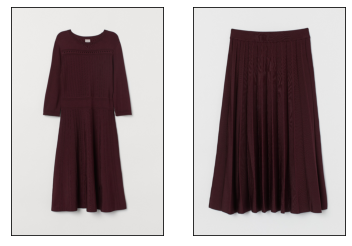

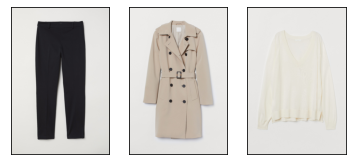

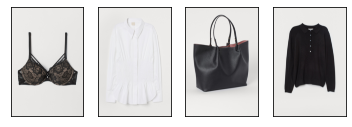

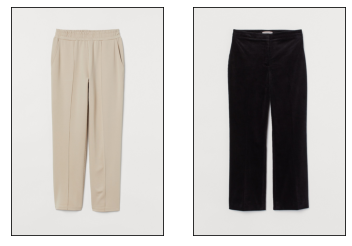

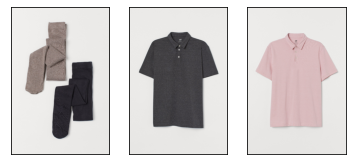

In [13]:
print("Items that customers buy together")
for _, data in transcation_aprori.head(5).iterrows():
    path = "../input/h-and-m-personalized-fashion-recommendations/images"
    f, ax = plt.subplots(1, len(data['article_id']), figsize=(6, 6))
    for i, article in enumerate(data['article_id']):
        file_name = "0" + str(article) + ".jpg"
        dir_name = "0" + str(article)[:2]
        image = mpimg.imread(path + "/" + dir_name + "/" + file_name)
        ax[i].imshow(image)
        ax[i].set_xticks([], [])
        ax[i].set_yticks([], [])
        ax[i].grid(False)
    plt.show()

### References

- https://towardsdatascience.com/the-frequently-bought-together-recommendation-system-b4ed076b24e5
- http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/
- http://rasbt.github.io/mlxtend/